In [2]:
import pandas as pd
import os

os.system("pip install emoji")

pd.set_option('display.max_columns', None)

df = pd.read_csv('../data/GroupMe Scam Message Dataset - Sheet1.csv')


dict_map = {
    0: 'Not Scam',
    1: 'Scam'
}

df['Scam'] = df['Scam'].map(dict_map)

df['Scam'].value_counts()


Scam
Scam        200
Not Scam    200
Name: count, dtype: int64

In [3]:
import emoji, re


def separate_emojis(text):
  if not isinstance(text, str):
    return ''
  return emoji.replace_emoji(text, replace=(lambda e, _: f' {str(e)} '))

In [4]:
df['Message'] = df['Message'].apply(separate_emojis)

df

,Scam,Message
0,Scam,"Hey guys, I'm looking to sell my full season ..."
1,Scam,@everyone Just upgraded! Giving away my old Ca...
2,Not Scam,Hi everyone!!! So sorry for late notice but to...
3,Scam,"Hey guys, I’m looking to sell my full season t..."
4,Not Scam,god bless the admin
...,...,...
395,Scam,I bought a game console for my little brother ...
396,Scam,My niece is in the hospital and I’ve been sell...
397,Scam,Lost two family members back to back and I’m s...
398,Scam,"Selling STAT400, CMSC131, and BMGT340 textbook..."


In [5]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

x = df['Message']
y = df['Scam']

x_train, x_test, y_train, y_test = train_test_split(
    x, y, random_state=67, stratify=y
)

In [6]:
vectorizer = TfidfVectorizer(stop_words='english')

x_train_vect = vectorizer.fit_transform(x_train)
x_test_vect = vectorizer.transform(x_test)

In [7]:

from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report,
                             accuracy_score,
                             precision_score,
                             recall_score,
                             make_scorer)

nb = MultinomialNB()
nb.fit(x_train_vect, y_train)







,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [8]:
from sklearn.metrics import confusion_matrix

y_train_pred = nb.predict(x_train_vect)
y_test_pred = nb.predict(x_test_vect)

print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_train, y_train_pred))
print("\nClassification Report:\n", classification_report(y_train, y_train_pred))


Accuracy: 0.9866666666666667

Confusion Matrix:
 [[147   3]
 [  1 149]]

Classification Report:
               precision    recall  f1-score   support

    Not Scam       0.99      0.98      0.99       150
        Scam       0.98      0.99      0.99       150

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



In [9]:
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

Accuracy: 0.82

Confusion Matrix:
 [[34 16]
 [ 2 48]]

Classification Report:
               precision    recall  f1-score   support

    Not Scam       0.94      0.68      0.79        50
        Scam       0.75      0.96      0.84        50

    accuracy                           0.82       100
   macro avg       0.85      0.82      0.82       100
weighted avg       0.85      0.82      0.82       100



In [10]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=67)

nb = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])

param_grid = {
    'tfidf__ngram_range' : [(1,1), (1,2), (1, 3), (1, 4)],
    'nb__alpha' : [0.1, 0.5, 1.0]
}

scoring = make_scorer(recall_score, pos_label='Scam')

x_vect = vectorizer.fit_transform(x)

grid = GridSearchCV(
    nb,
    param_grid=param_grid,
    cv=kf,
    scoring=scoring,
    n_jobs=-1,
    verbose=3
)

grid.fit(x, y)

print("Naive Bayes Best:", grid.best_params_)
print("Best CV Recall:", grid.best_score_)
best_nb = grid.best_estimator_


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END nb__alpha=0.1, tfidf__ngram_range=(1, 1);, score=0.950 total time=   0.0s
[CV 4/5] END nb__alpha=0.1, tfidf__ngram_range=(1, 2);, score=0.975 total time=   0.0s
[CV 5/5] END nb__alpha=0.1, tfidf__ngram_range=(1, 2);, score=0.950 total time=   0.0s
[CV 1/5] END nb__alpha=0.1, tfidf__ngram_range=(1, 2);, score=0.975 total time=   0.0s
[CV 4/5] END nb__alpha=0.1, tfidf__ngram_range=(1, 1);, score=0.925 total time=   0.0s
[CV 2/5] END nb__alpha=0.1, tfidf__ngram_range=(1, 1);, score=0.925 total time=   0.0s
[CV 3/5] END nb__alpha=0.1, tfidf__ngram_range=(1, 2);, score=0.900 total time=   0.0s
[CV 3/5] END nb__alpha=0.1, tfidf__ngram_range=(1, 1);, score=0.900 total time=   0.0s
[CV 5/5] END nb__alpha=0.1, tfidf__ngram_range=(1, 1);, score=0.950 total time=   0.0s
[CV 2/5] END nb__alpha=0.1, tfidf__ngram_range=(1, 2);, score=0.925 total time=   0.0s
[CV 1/5] END nb__alpha=0.1, tfidf__ngram_range=(1, 3);, score=0.925 t

In [11]:
print(classification_report(y_test, best_nb.predict(x_test)))

              precision    recall  f1-score   support

    Not Scam       1.00      0.98      0.99        50
        Scam       0.98      1.00      0.99        50

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



Matplotlib is building the font cache; this may take a moment.


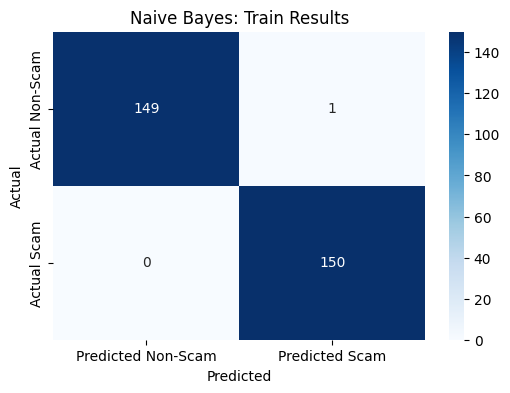

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_train_pred = best_nb.predict(x_train)

cm = confusion_matrix(y_train, y_train_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Non-Scam','Predicted Scam'],
            yticklabels=['Actual Non-Scam','Actual Scam'])
plt.title('Naive Bayes: Train Results')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

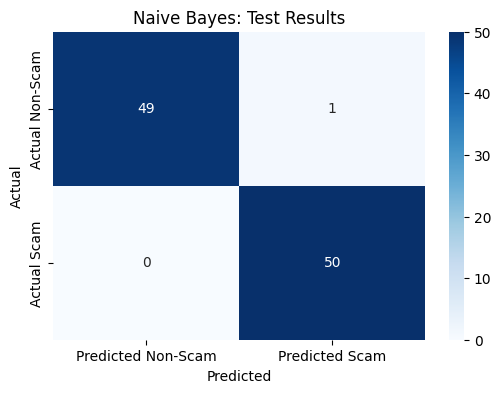

In [13]:
y_test_pred = best_nb.predict(x_test)
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Non-Scam','Predicted Scam'],
            yticklabels=['Actual Non-Scam','Actual Scam'])
plt.title('Naive Bayes: Test Results')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [14]:
best_nb.classes_

array(['Not Scam', 'Scam'], dtype='<U8')

In [15]:
best_nb.predict_proba(["I'm giving away my taylor swift tickets"])

array([[0.34526037, 0.65473963]])

In [16]:
data = [
    ("Scam", "🚨 URGENT: Your UMD Directory Account will be SUSPENDED in 24 hours. Verify immediately: http://umd-security-check-412.com/verify"),
    ("Scam", "📦 USPS: We couldn't deliver your package #7721893. Pay the $1.50 redelivery fee: http://usps-redeliver-pay.info"),
    ("Scam", "⚠️ Bank Alert: A $1,083.22 withdrawal attempt was blocked. Review activity: https://secure-chase-verify.net"),
    ("Scam", "GroupMe Admin: Your account was flagged for bot-like activity. Appeal decision here: http://groupme-review-appeal247.io"),
    ("Scam", "Netflix Billing: Your payment was declined. Update info to avoid cancellation: http://netflix-authcenter-88.com"),
    ("Scam", "Apple ID Locked: Suspicious login from Springfield, IL. Restore access: http://apple-restore-now.net/login"),
    ("Scam", "UMD Parking: You have an unpaid violation (#981223). Pay immediately to avoid towing: http://umd-payfine-portal.io"),
    ("Scam", "IRS Notice: You owe $298.14 in unpaid taxes. Resolve now to avoid penalties: http://irs-resolution-case729.com"),
    ("Scam", "PayPal: We noticed unauthorized access. Confirm your identity: http://pp-security-check247.net"),
    ("Scam", "Your Amazon order #114-5528821 is on hold due to billing failure. Fix it: http://amazon-billing-center.cc"),
    ("Scam", "Hey guys,  kindly reach out for quality and affordable professional academic writing services in your ■Fall online classes ■Exams. ■Assignments. ■Essay. ■Mathematics. ■Research papers. ■Dissertation. ■Quizzes. ■Discussions. ■Projects Hmu on: 👇👇 EMAIL: @Topwriter980@gmail.com Snap: @premium_essays. Text/Call: +1 (914) 291-0451. https://wa.me/message/IG6FWWFYGUKTA1"),
    ("Scam", "Selling Penn state ticket Dm if interested"),
    ("Scam", "Hello 👋 @everyone\"Just upgraded! Giving away my old Canon camera. It's still functional and in good shape. Perfect for photography enthusiasts or anyone wanting to start! DM me if interested in picking it up. 🙌 here is my WhatsApp number +1 7328812350or iMessage nk6031327@gmail.com"),
    ("Scam", "Hey guys, I’m looking to sell my full season tickets, I can sell them individually Whoever wants them should text me tysm!"),
    ("Scam", "Hey🫶! idk if anyone is interested in getting my tickets to Gunna concert.HMU if interested"),
    ("Scam" , "i’ve got 4 6LACK tickets for thu Oct 9, 2025 at the Kaseya Center miami.also have my full season ticket for sale,pm"),
    ("Not Scam", "Hey, did you still want to meet at Stamp around 3?"),
    ("Not Scam", "UMD alert: Campus will be closing early due to severe weather."),
    ("Not Scam", "Dinner tonight? Thinking noodles or something warm."),
    ("Not Scam", "Reminder: Your CS discussion section is canceled tomorrow."),
    ("Not Scam", "Got your payment for rent, thanks!"),
    ("Not Scam", "Don’t forget the group meeting at 7. I’ll send the Zoom link soon."),
    ("Not Scam", "Package delivered: Your Amazon item has been placed at your front door."),
    ("Not Scam", "Running late to gym. Be there in 15."),
    ("Not Scam", "Your UMD parking permit renewal opens next Monday."),
    ("Not Scam", "Sending the notes now. Let me know if the PDF doesn’t load."),
    ("Not Scam", "Who having the Super Bowl watch parties?"),
    ("Not Scam", "Get your FREE tickets NOW at https://www.eventbrite.com/e/810745761397?aff=oddtdtcreator⁠ MICA will have FREE food, giveaways, selfie photobooth and outside guests are welcome! We're giving a prize to the most creative hairstyle of the night! So get ready to shine like the stars you are."),
    ("Not Scam", "Paragon One has a fully remote externship program where you can gain experience from your dorm:\n6-8 week externships\n2-4 week labs\nFlexible, part-time schedule\nHost companies include PWC, Beats By Dr. Dre, Hugo Boss, and more\nStipends up to $750 available\nApply with this link for priority application review:"),
    ("Not Scam", "if anyone needs an iowa ticket dm"),
    ("Not Scam", "anybody have iowa basketball tickets ?")
]

sample = pd.DataFrame(data, columns=["Scam", "Message"])
sample

,Scam,Message
0,Scam,🚨 URGENT: Your UMD Directory Account will be S...
1,Scam,📦 USPS: We couldn't deliver your package #7721...
2,Scam,"⚠️ Bank Alert: A $1,083.22 withdrawal attempt ..."
3,Scam,GroupMe Admin: Your account was flagged for bo...
4,Scam,Netflix Billing: Your payment was declined. Up...
5,Scam,Apple ID Locked: Suspicious login from Springf...
6,Scam,UMD Parking: You have an unpaid violation (#98...
7,Scam,IRS Notice: You owe $298.14 in unpaid taxes. R...
8,Scam,PayPal: We noticed unauthorized access. Confir...
9,Scam,Your Amazon order #114-5528821 is on hold due ...


In [17]:
sample_x = sample['Message']
sample_y = sample['Scam']

print(classification_report(sample_y, best_nb.predict(sample_x)))

              precision    recall  f1-score   support

    Not Scam       0.92      0.73      0.81        15
        Scam       0.79      0.94      0.86        16

    accuracy                           0.84        31
   macro avg       0.85      0.84      0.84        31
weighted avg       0.85      0.84      0.84        31



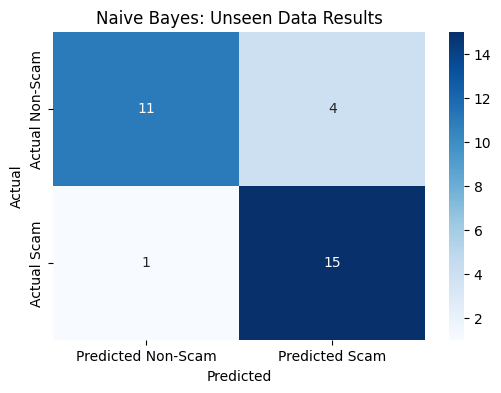

In [18]:
y_test_pred = best_nb.predict(x_test)
cm = confusion_matrix(sample_y, best_nb.predict(sample_x))

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Non-Scam','Predicted Scam'],
            yticklabels=['Actual Non-Scam','Actual Scam'])
plt.title('Naive Bayes: Unseen Data Results')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()